<h1 style="color:orange">QDA Exam - 06/06/2024</h1> 
Francesco Marco Riboli - 10502512 - 8CFU

# Exercise 1

In [26]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
from statsmodels.tsa.arima.model import ARIMA

# Import the dataset
data = pd.read_csv('240606_ex1.csv')

# Inspect the dataset
data.head()

,Sample,Concentration
0,1,8.36
1,2,12.72
2,3,8.60
3,4,7.72
4,5,5.97


In [27]:
data.describe()

,Sample,Concentration
count,50.0000,50.0000
mean,25.5000,10.1150
std,14.5774,5.3482
min,1.0000,-0.3500
25%,13.2500,6.2800
50%,25.5000,8.7550
75%,37.7500,13.8050
max,50.0000,19.6700


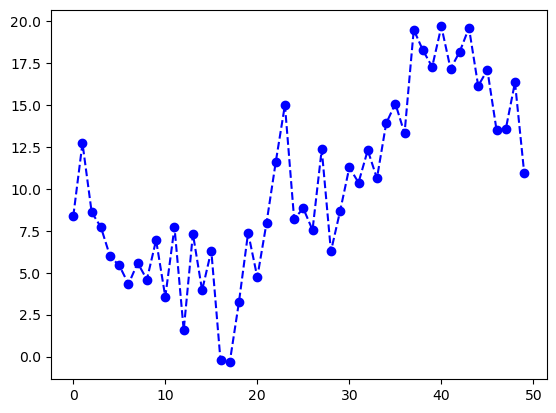

In [28]:
# Plot the data first
plt.plot(data['Concentration'], color='b', linestyle='--', marker='o')

As stated by the text, the negative values are due to a temporary miscalibration, so we better remove them from the datatset

In [29]:
# Remove rows with negative values
data = data[data['Concentration'] >= 0]

#Reindexing the dataset
data.index = pd.Index(range(len(data)))
data.describe()


,Sample,Concentration
count,48.0000,48.0000
mean,25.8333,10.5485
std,14.7883,5.0021
min,1.0000,1.5700
25%,12.7500,6.7825
50%,26.5000,9.6000
75%,38.2500,14.1650
max,50.0000,19.6700


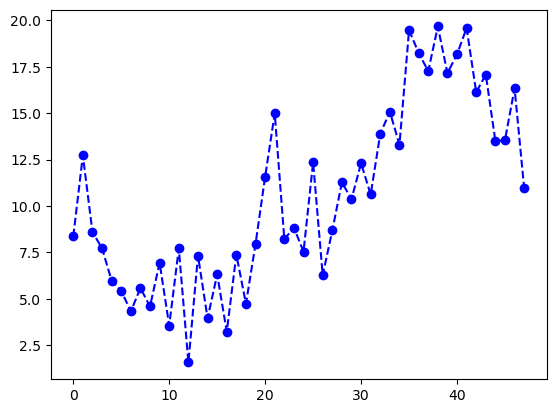

In [30]:

# Plot the data again
plt.plot(data['Concentration'], color='b', linestyle='--', marker='o')
plt.show()


## a) Fitting of the appropriate model to the dataset

In [31]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data['Concentration'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

Runs test p-value = 0.000


> The runs test gives a null p-value, this means that the data are <span style="color:red"> not random </span>. 
>
> Plot also the autocorrelation and partial autocorrelation functions of the data. Use the `plot_acf` and `plot_pacf` functions from the `statsmodels` package.

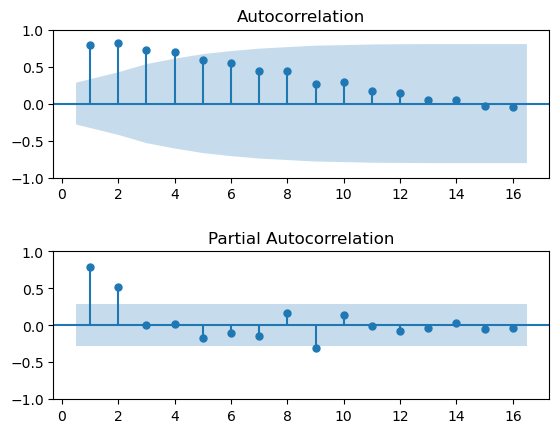

In [32]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['Concentration'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['Concentration'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> The process is NON-STATIONARY.
>
> Let's try to apply the difference operator.

In [33]:
# Difference the data
data['diff1'] = data['Concentration'].diff(1).dropna()

data.describe()

,Sample,Concentration,diff1
count,48.0000,48.0000,47.0000
mean,25.8333,10.5485,0.0551
std,14.7883,5.0021,3.2842
min,1.0000,1.5700,-6.7800
25%,12.7500,6.7825,-2.1500
50%,26.5000,9.6000,0.0600
75%,38.2500,14.1650,2.5000
max,50.0000,19.6700,6.1700


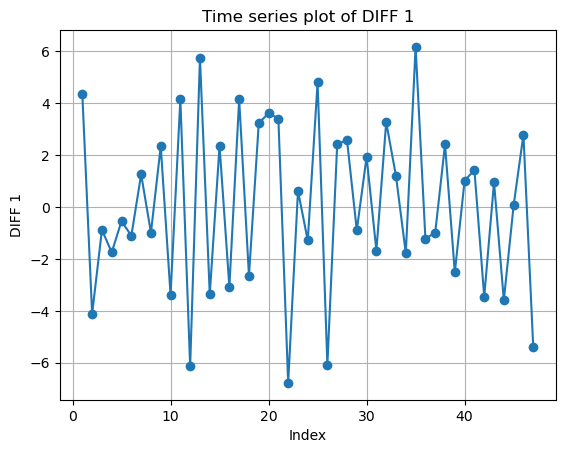

In [34]:
plt.plot(data['diff1'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF 1')
plt.title('Time series plot of DIFF 1')
plt.grid()
plt.show()

> Let's verify again the time dependence assumption with runs test and ACF/PACF on the DIFF1 data

Runs test p-value = 0.001


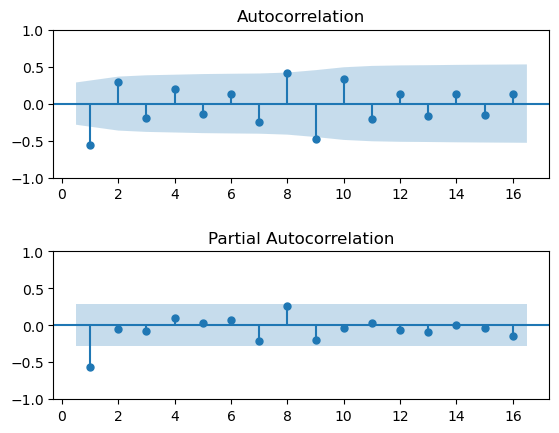

In [35]:
_, pval_runs = runstest_1samp(data['diff1'][1:], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data['diff1'][1:], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

> After the differencing operation, the most suitable model seems to be an MA(1). Thus the investigated model is ARIMA(p,q,d)

In [36]:
# fit model ARIMA
x = data['Concentration'] #TrainingData

# fit model ARIMA
p=1
d=1
q=0
# Fit the ARIMA model
arima = ARIMA(x, order=(p, d, q))
model = arima.fit()

qda.ARIMAsummary(model)

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ar.L1 -0.6066   0.1193  -5.0856 3.6638e-07

RESIDUAL SUM OF SQUARES
-------------------------
  DF       SS     MS
46.0 330.3696 7.1819

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      9.7337   0.6393
  24     15.7270   0.8977
  36     21.1599   0.9767


Shapiro-Wilk test p-value = 0.221


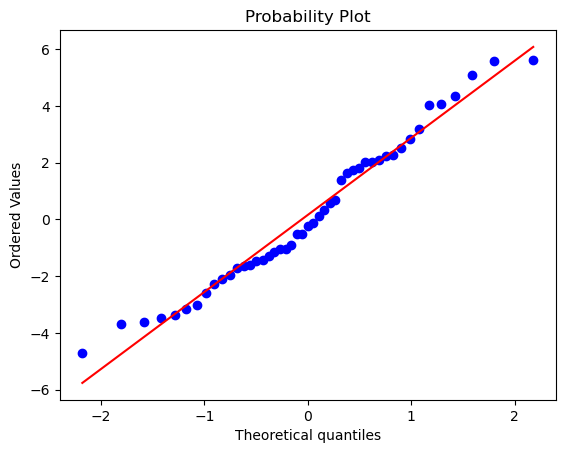

In [37]:
#extract the residuals
residuals = model.resid[np.max((p,d,q)):] 

#extract the fitted values
fits = model.fittedvalues[np.max((p,d,q)):] 
 
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Runs test p-value = 0.085


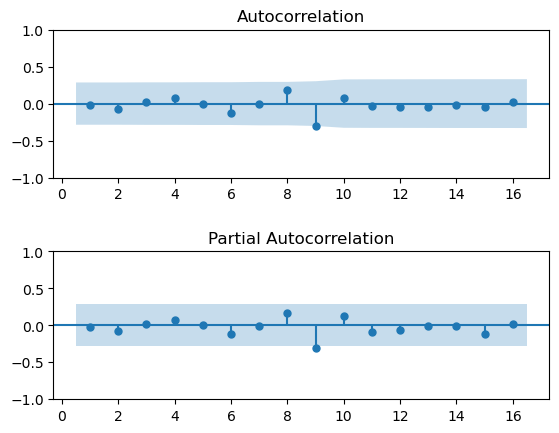

In [38]:
#RANDOMNESS OF MODEL RESIDUALS
_, pval_runs = runstest_1samp(residuals, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

The runs test gives a value higher than 0.05: the test is acceptable

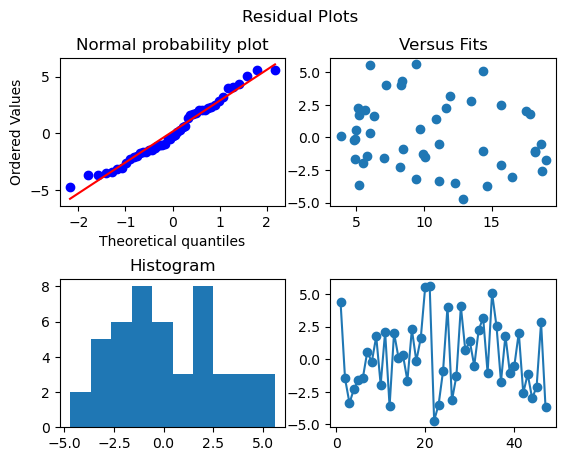

In [39]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

The obtained residuals are IID. The model ARIMA(0,1,1) is adeguate

## b) Estimate the 95% prediction interval for the contaminant concentration in the next sample
As the model is fitted on differenced data, we can find the 95% PI Interval on the differenced 51st sample. By summing the values to the 50th sample we can find the actual 51st sample interval

Predicted value for step 1: 14.21930720403097
95% Prediction Interval for step 1: [9.078269948036366, 19.360344460025573]


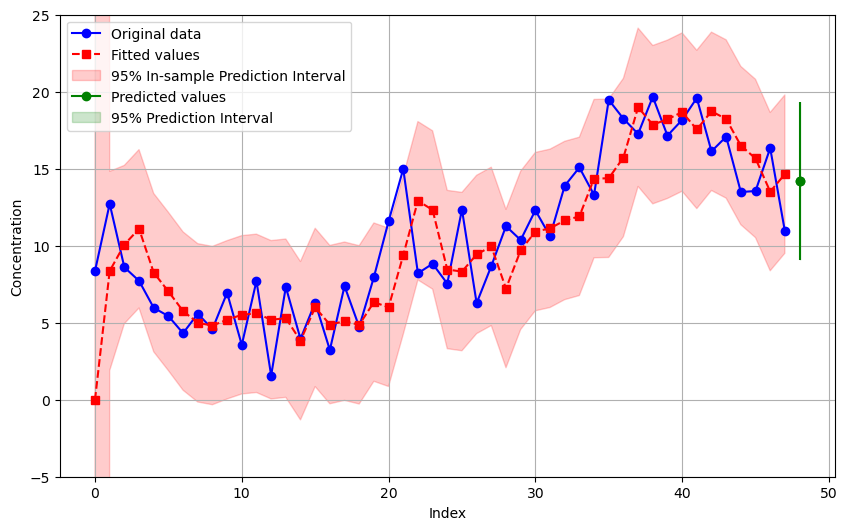

In [41]:
# Generate the forecast for the next values (horizon=Nsteps)
Nsteps = 1
forecast_result = model.get_forecast(steps=Nsteps)

# Get the predicted values and the prediction intervals
predicted_values = forecast_result.predicted_mean
prediction_intervals = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
lower_bounds = prediction_intervals.iloc[:, 0]
upper_bounds = prediction_intervals.iloc[:, 1]

# Print the results
for i in range(Nsteps):
    print(f"Predicted value for step {i+1}: {predicted_values.iloc[i]}")
    print(f"95% Prediction Interval for step {i+1}: [{lower_bounds.iloc[i]}, {upper_bounds.iloc[i]}]")

# Obtain in-sample predictions and their confidence intervals
in_sample_preds = model.get_prediction()
in_sample_ci = in_sample_preds.conf_int()

# Plot the data, the model's fitted values, and the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(data['Concentration'], 'o-', color='blue', label='Original data')
plt.plot(model.fittedvalues, 's--', color='red', label='Fitted values')

# Plot the in-sample confidence intervals
plt.fill_between(data.index, in_sample_ci.iloc[:, 0], in_sample_ci.iloc[:, 1], color='red', alpha=0.2, label='95% In-sample Prediction Interval')

# Plot the multi-step predictions and their intervals
forecast_index = range(len(data), len(data) + Nsteps)
plt.plot(forecast_index, predicted_values, 'o-', color='green', label='Predicted values')
plt.fill_between(forecast_index, lower_bounds, upper_bounds, color='green', alpha=0.2, label='95% Prediction Interval')

# Highlight the prediction intervals for each step
for i in range(Nsteps):
    plt.errorbar(len(data) + i, predicted_values.iloc[i], yerr=[[predicted_values.iloc[i] - lower_bounds.iloc[i]], [upper_bounds.iloc[i] - predicted_values.iloc[i]]], fmt='o', color='green')

# Plot settings
plt.ylim(-5, 25)
plt.xlabel('Index')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


## c) Based on the result of point a), design an appropriate control chart for these data with ARL0 = 250.  

In [16]:
ARL0=250 #Average Run Lenght
typeIerror=1/ARL0
print(typeIerror)

0.004


We will use an I-MR Control Chart for the current application


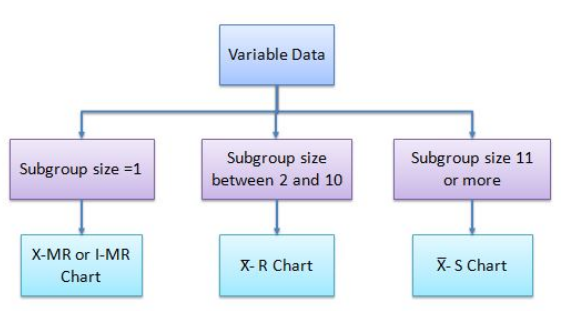

Let's plot the residuals to which we will fit the I-MR Chart. From the previous steps we know that the residuals data is IID.

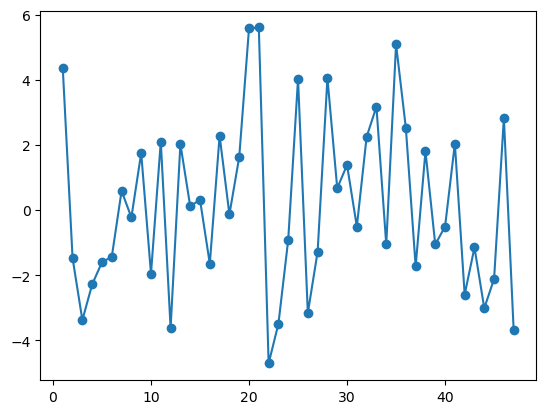

In [17]:
# Convert residuals to DataFrame
residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
# Plot the data
plt.plot(residuals_df['Residuals'], 'o-')
plt.show()

In [18]:
# Find k value
from scipy.stats import norm, boxcox, shapiro
k = norm.ppf(1 - typeIerror / 2)
print(k)

2.878161739095483


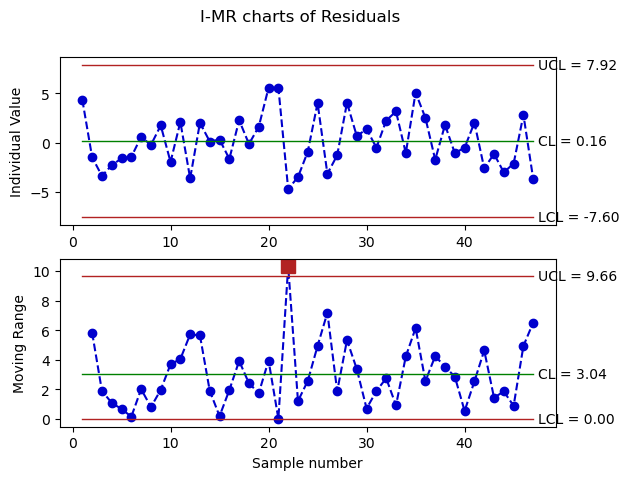

,Residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
1,4.3601,NaN,7.9172,0.1581,-7.601,NaN,9.6566,3.0419,0,NaN
2,-1.4754,5.8355,7.9172,0.1581,-7.601,NaN,9.6566,3.0419,0,NaN
3,-3.3790,1.9035,7.9172,0.1581,-7.601,NaN,9.6566,3.0419,0,NaN
4,-2.2838,1.0952,7.9172,0.1581,-7.601,NaN,9.6566,3.0419,0,NaN
5,-1.6015,0.6823,7.9172,0.1581,-7.601,NaN,9.6566,3.0419,0,NaN


In [19]:
import qda
data_IMR = qda.ControlCharts.IMR(residuals_df,'Residuals',k)
data_IMR.head()

Let's find the OOC point in the MR chart

In [20]:
# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['MR_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [21]


Shapiro-Wilk test p-value for Original MR = 0.009


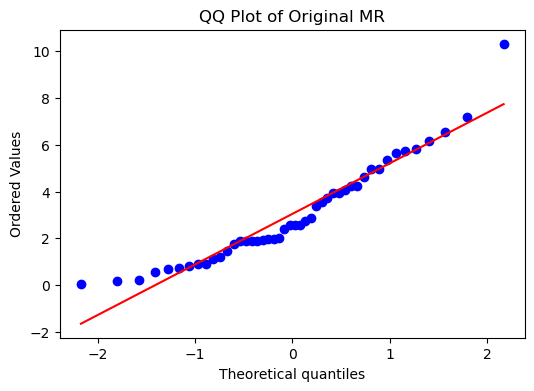

In [21]:
# Verify normality of the transformed MR data
shapiro_stat, shapiro_p_value = shapiro(data_IMR['MR'].dropna())
print(f'Shapiro-Wilk test p-value for Original MR = {shapiro_p_value:.3f}')

# Plot the QQ plot of transformed MR
plt.figure(figsize=(6, 4))
stats.probplot(data_IMR['MR'].dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Original MR')
plt.show()

(array([ 9., 12.,  6.,  6.,  5.,  5.,  2.,  0.,  0.,  1.]),
 array([ 0.0266,  1.0556,  2.0847,  3.1138,  4.1429,  5.172 ,  6.201 ,
         7.2301,  8.2592,  9.2883, 10.3174]),
 <BarContainer object of 10 artists>)

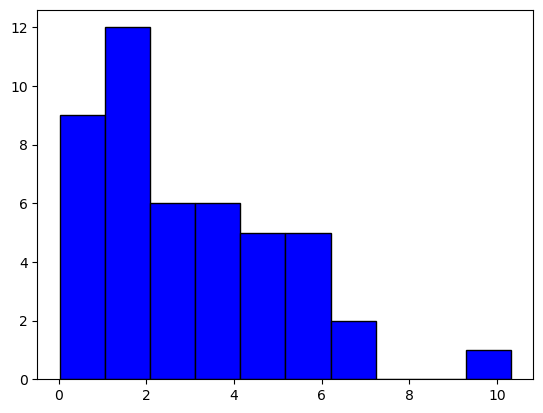

In [22]:
plt.hist(data_IMR['MR'], color='blue', edgecolor='black')

When verifying the normality of the MR chart we find a non-normal distribution (half normal, per consturction), it's necessary to transform it and do again the I-MR chart

In [23]:
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])
MR['MR'] = MR['MR'].transform(lambda x: ((x**0.4)))

p-value of the Shapiro-Wilk test: 0.868


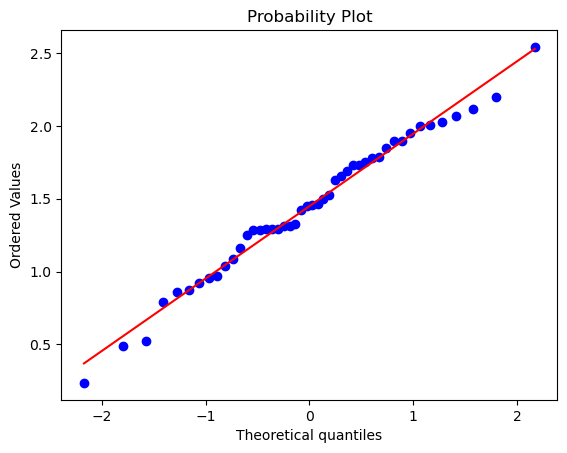

In [24]:
# We can use the Shapiro-Wilk test
data_MR_transformed_dropna = MR.dropna()
_, p_value_SW = stats.shapiro(data_MR_transformed_dropna['MR'])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_MR_transformed_dropna['MR'], dist="norm", plot=plt)
plt.show()

> Now you can use the I chart on the transformed data.

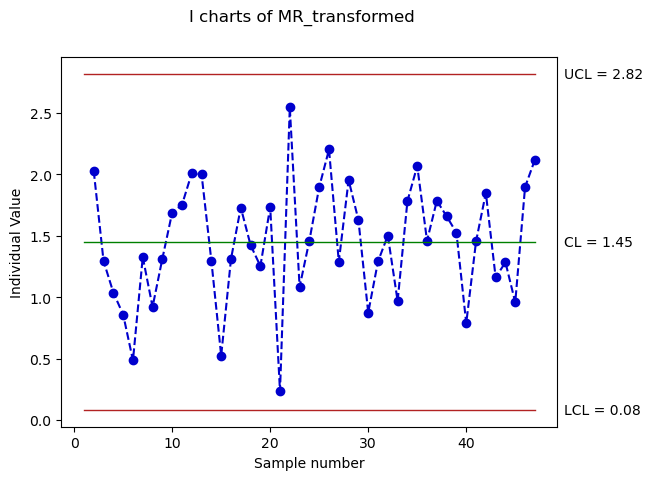

In [25]:
# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = k, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()


## d) From  historical  data,  it  is  known  that  the  most  appropriate  model  for  this  process  yielded  a  standard deviation of residuals equal to 𝜎𝜀 =2.5. Determine, with a statistical test, if the model fitted at point a) is such that the standard deviation of residuals is greater than this value (report also the p-value of the test). Discuss the result.

Since model residuals are normal and independent, it is possible to perform a one sample chi-squared test as follows.

In [28]:
# Calculate the MSE and estimate the standard deviation of the residuals
mse = np.mean(residuals**2)
sigma_hat = np.sqrt(mse)
print(f"Estimated standard deviation (sigma_hat) = {sigma_hat:.3f}")

Estimated standard deviation (sigma_hat) = 2.651


In [29]:
from scipy.stats import chi2

# Perform the chi-squared test
sigma_0 = 2.5  # Given historical standard deviation
p = 2  # Number of model terms
n = len(residuals)
print(f"n = {n:.0f}")
test_statistic = (n - p) * (sigma_hat**2 / sigma_0**2)
p_value = 1 - chi2.cdf(test_statistic, df=n-p)

print(f"Chi-squared test statistic = {test_statistic:.3f}")
print(f"p-value = {p_value:.3f}")

# Decision based on p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The standard deviation of residuals is greater than 2.5")
else:
    print("Fail to reject the null hypothesis: The standard deviation of residuals is not significantly greater than 2.5")

n = 47
Chi-squared test statistic = 50.610
p-value = 0.262
Fail to reject the null hypothesis: The standard deviation of residuals is not significantly greater than 2.5


# Exercise 2

## a) Estimate and draw the curves of 𝐴𝑅𝐿1 as a function of the mean shift 𝛿 expressed in standard deviation units with a sample size 𝑛=4 and 𝑛=8, respectively
Show the two curves for 𝛿 ∈ [0;2] and report the 𝐴𝑅𝐿1 values for 𝛿 =1 and 𝛿 =2

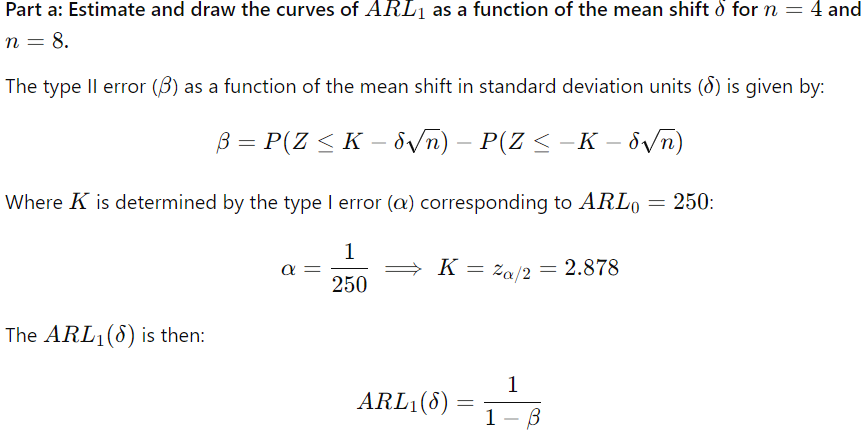

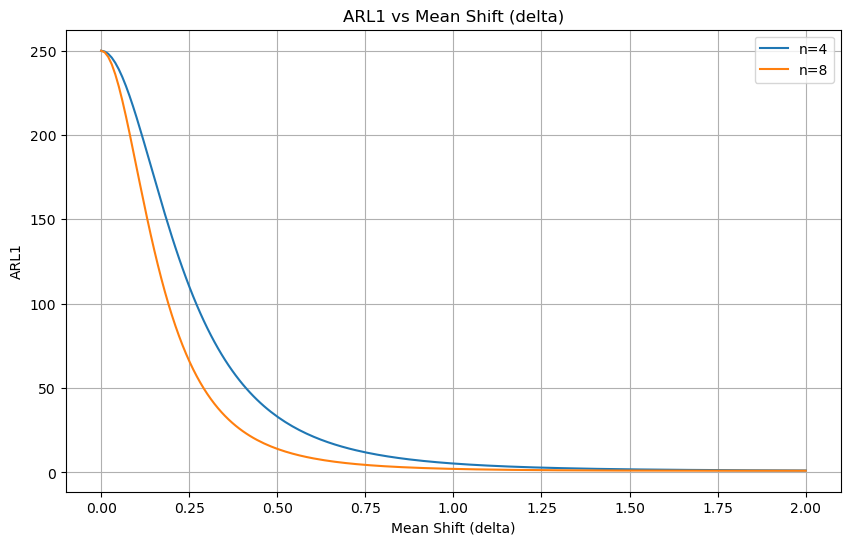

{'n=4, delta=1': 5.263922681926537,
 'n=4, delta=2': 1.150656913415669,
 'n=8, delta=1': 2.082329533375815,
 'n=8, delta=2': 1.0027350096597252}

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Constants
K = 2.878
delta_values = np.linspace(0, 2, 200)

# Function to calculate beta
def calculate_beta(delta, n):
    return norm.cdf(K - delta * np.sqrt(n)) - norm.cdf(-K - delta * np.sqrt(n))

# Function to calculate ARL1
def calculate_arl1(delta, n):
    beta = calculate_beta(delta, n)
    return 1 / (1 - beta)

# Calculate ARL1 for n = 4 and n = 8
arl1_n4 = [calculate_arl1(delta, 4) for delta in delta_values]
arl1_n8 = [calculate_arl1(delta, 8) for delta in delta_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(delta_values, arl1_n4, label='n=4')
plt.plot(delta_values, arl1_n8, label='n=8')
plt.xlabel('Mean Shift (delta)')
plt.ylabel('ARL1')
plt.title('ARL1 vs Mean Shift (delta)')
plt.legend()
plt.grid(True)
plt.show()

# ARL1 values for delta = 1 and delta = 2
arl1_n4_delta1 = calculate_arl1(1, 4)
arl1_n4_delta2 = calculate_arl1(2, 4)
arl1_n8_delta1 = calculate_arl1(1, 8)
arl1_n8_delta2 = calculate_arl1(2, 8)

arl1_values = {
    "n=4, delta=1": arl1_n4_delta1,
    "n=4, delta=2": arl1_n4_delta2,
    "n=8, delta=1": arl1_n8_delta1,
    "n=8, delta=2": arl1_n8_delta2
}

arl1_values

## b) Estimate and draw the curves of 𝐴𝑅𝐿1 as a function of the sample size 𝑛 for two values of the shift, 𝛿=1 and 𝛿=2, where 𝛿 is expressed in standard deviation units
Show the two curves for 𝑛 ∈ [2;20] and report the 𝐴𝑅𝐿1 values for 𝑛=3 and 𝑛=6. The type II error (𝛽) is given by the same expression as above. We need to calculate ARL_1 for varying 𝑛.

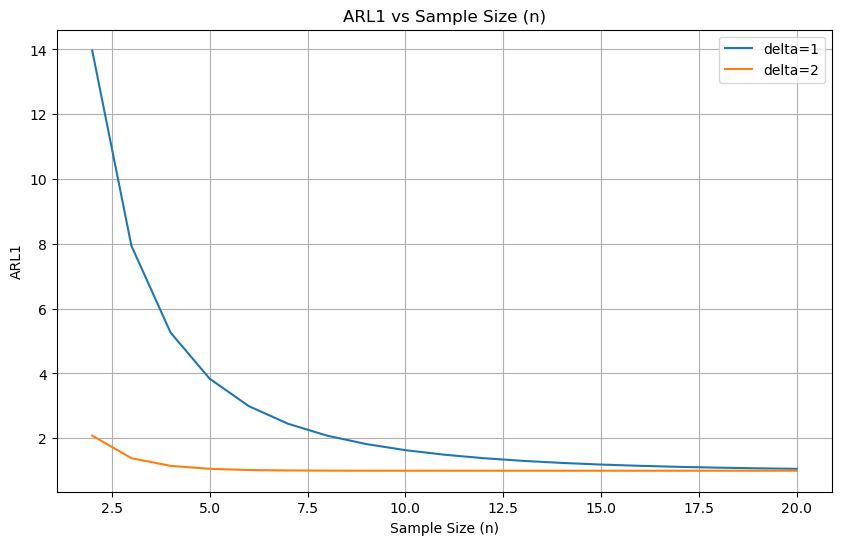

{'delta=1, n=3': 7.942174585601631,
 'delta=1, n=6': 2.992758570395829,
 'delta=2, n=3': 1.3867771650606824,
 'delta=2, n=6': 1.022119634145001}

In [31]:
# Sample sizes
n_values = np.arange(2, 21)

# Calculate ARL1 for delta = 1 and delta = 2
arl1_delta1 = [calculate_arl1(1, n) for n in n_values]
arl1_delta2 = [calculate_arl1(2, n) for n in n_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, arl1_delta1, label='delta=1')
plt.plot(n_values, arl1_delta2, label='delta=2')
plt.xlabel('Sample Size (n)')
plt.ylabel('ARL1')
plt.title('ARL1 vs Sample Size (n)')
plt.legend()
plt.grid(True)
plt.show()

# ARL1 values for n = 3 and n = 6
arl1_n3_delta1 = calculate_arl1(1, 3)
arl1_n3_delta2 = calculate_arl1(2, 3)
arl1_n6_delta1 = calculate_arl1(1, 6)
arl1_n6_delta2 = calculate_arl1(2, 6)

arl1_values_n = {
    "delta=1, n=3": arl1_n3_delta1,
    "delta=1, n=6": arl1_n6_delta1,
    "delta=2, n=3": arl1_n3_delta2,
    "delta=2, n=6": arl1_n6_delta2
}

arl1_values_n

## c) Optimal sample size 𝑛 to minimize the lack of quality costs.
The head of the quality control department is interested in selecting an optimal sample size 𝑛 to minimize the lack of quality costs in the presence of a mean shift equal to 𝛿 =2 standard deviation units. Knowing that samples are gathered every 4 hours, the cost of planarity measurements for each laminate is 𝐶1 = 2€ and an extra cost equal to 𝐶2 = 15€ is due for each hour spent in the out-of-control state, determine the optimal sample  size that minimizes the  overall expected  costs (assume the cost of the  process in its in-control state as a reference baseline). Discuss the results. 

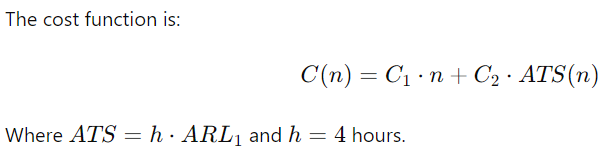

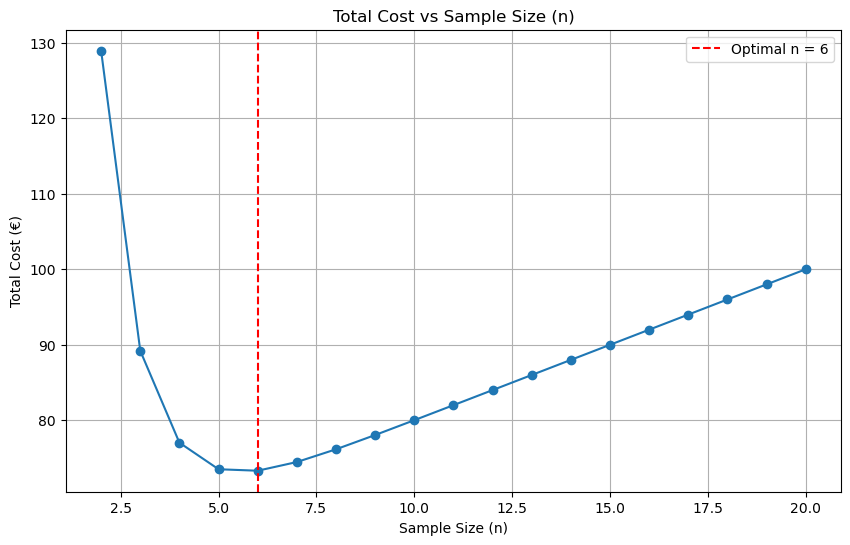

Optimal Sample size = 6


In [32]:
# Constants for costs
C1 = 2
C2 = 15
h = 4

# Function to calculate the total cost
def calculate_total_cost(n, delta):
    arl1 = calculate_arl1(delta, n)
    ats = h * arl1
    return C1 * n + C2 * ats

# Calculate total cost for delta = 2
costs = [calculate_total_cost(n, 2) for n in n_values]

# Find the optimal sample size
optimal_n = n_values[np.argmin(costs)]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, costs, marker='o')
plt.xlabel('Sample Size (n)')
plt.ylabel('Total Cost (€)')
plt.title('Total Cost vs Sample Size (n)')
plt.axvline(optimal_n, color='r', linestyle='--', label=f'Optimal n = {optimal_n}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Sample size = {optimal_n}")

### Analysis of Point c Result

The graph shows the total cost as a function of the sample size (\(n\)). Here are the key observations and conclusions:

1. **Cost Behavior**:
   - The total cost decreases sharply as the sample size increases from 2 to 6.
   - After reaching a minimum, the total cost starts to increase again as the sample size continues to grow beyond 6.

2. **Optimal Sample Size**:
   - The optimal sample size, which minimizes the overall expected costs, is \(n = 6\). This is indicated by the red dashed line in the graph.
   - At \(n = 6\), the total cost is at its lowest point, approximately €77.

3. **Cost Components**:
   - The total cost consists of two components: the cost of planarity measurements (\(C_1 \cdot n\)) and the extra cost due to the time spent in the out-of-control state (\(C_2 \cdot ATS(n)\)).
   - For smaller sample sizes (\(n < 6\)), the extra cost due to the time in the out-of-control state dominates. This is because smaller sample sizes result in higher ARL1 values, leading to longer times before detecting an out-of-control condition.
   - For larger sample sizes (\(n > 6\)), the cost of planarity measurements becomes dominant. This is because more frequent measurements increase the direct cost of sampling.

4. **Balancing Costs**:
   - The optimal sample size \(n = 6\) represents a balance point where the combined cost of sampling and the cost associated with delayed detection is minimized.
   - This indicates an efficient trade-off between frequent sampling (to quickly detect out-of-control conditions) and the cost of performing those measurements.

In conclusion, the result highlights that careful consideration of both the measurement costs and the costs associated with delayed detection is crucial in determining the optimal sampling strategy. By choosing an optimal sample size of \(n = 6\), the company can minimize its overall costs, ensuring effective monitoring of the process while keeping expenses under control.

The theory question is worth only 3 points, considering a total of 33/30 points, I won't do it